In [36]:
import numpy as np
import os
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord 
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
import pyccl
from scipy import stats
from scipy.optimize import curve_fit

os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm.support.sampler import fitters

from importlib import reload  

import sys
sys.path.append('../../')
from magnification_library import *

In [37]:
clmm.__version__

'1.0.0'

In [38]:
matplotlib.rcParams.update({'font.size': 14})

In [39]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [40]:
path_file = '../../../'

In [41]:
key = 'LBGp'

## **Profiles measured with TreeCorr**

In [42]:
quant = np.load(path_file + "output_data/binned_correlation_fct_arcmin_"+key+".npy", allow_pickle=True)
quant_NK = np.load(path_file + "output_data/binned_correlation_fct_NK_arcmin_"+key+".npy", allow_pickle=True)

## **Measuring profiles with astropy and CLMM**


## Open data

In [43]:
gal_cat_raw =  pd.read_hdf(path_file+'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file+"input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, alpha_cut_err, mag_null, gal_dens, zmean = dat[np.where(dat[:,0]==key)][0][1:]

print (alpha_cut)
mag_cut

3.3193084709750664


25.499950000000002

In [44]:
selection_source = (gal_cat_raw['ra']>50) & (gal_cat_raw['ra']<73.1) & (gal_cat_raw['dec']<-27.) & (gal_cat_raw['dec']>-45.)
selection = selection_source & (gal_cat_raw['mag_i_lsst']<mag_cut) & (gal_cat_raw['redshift']>1.5)

gal_cat = gal_cat_raw[selection]

In [45]:
[z_cl, mass_cl, n_halo] = np.load(path_file + "output_data/halo_bin_properties.npy", allow_pickle=True)

In [46]:
np.sum(n_halo)

21982.0

## Open halo catalog and define binning

In [47]:
halo_cat =  pd.read_hdf(path_file + 'input_data/cat_halos.h5')
ra_min  = 50 
ra_max  = 73.1
dec_min = -45
dec_max = -27
selection_halo = ( halo_cat['ra']>ra_min) & ( halo_cat['ra']<ra_max) & ( halo_cat['dec']<dec_max) & ( halo_cat['dec']>dec_min)

In [48]:
zbins = np.array(([0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1.0], [1.0, 1.2]))

In [49]:
mbins = np.array(([20,30],[30,45],[45,70],[70,120],[120,220]))*(1e14/45)

In [50]:
bin_sel = np.zeros((zbins.shape[0], mbins.shape[0]), dtype=object)
for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        bin_sel[i,j] = selection_halo & (halo_cat['redshift']> zbins[i][0]) & (halo_cat['redshift']< zbins[i][1]) & (halo_cat['halo_mass']> mbins[j][0]) & (halo_cat['halo_mass']< mbins[j][1])

In [51]:
wide_selection = selection_halo *  (halo_cat['redshift']> zbins.min()) & (halo_cat['redshift']< zbins.max()) & (halo_cat['halo_mass']> mbins.min()) & (halo_cat['halo_mass']< mbins.max())

/pbs/throng/lsst/users/mricci/desc/my_clean_env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [52]:
np.sum(wide_selection)

21982

## Select source galaxies around clusters

In [53]:
source = SkyCoord(gal_cat.ra.values*u.deg, gal_cat.dec.values*u.deg)

In [54]:
match = np.zeros(z_cl.shape, dtype=object)
match_rand = np.zeros(z_cl.shape, dtype=object)

In [55]:
#rmin_Mpc, rmax_Mpc = 0.1*u.Mpc, 7*u.Mpc
rmin_Mpc, rmax_Mpc = 0.1*u.Mpc, 3.5*u.Mpc

bin_dict={'min_sep':0.1, 'max_sep':20, 'sep_units':'arcmin','bin_type':'Log','nbins':10, 'var_method':'shot'}



for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        #conv = cosmo.arcsec_per_kpc_proper(z_cl[i,j]).to(u.arcmin/u.Mpc)
        #sep_max = conv * rmax_Mpc
        lens = SkyCoord(halo_cat[bin_sel[i,j]].ra.values*u.deg, halo_cat[bin_sel[i,j]].dec.values*u.deg)
        match[i,j] = source.search_around_sky(lens, bin_dict['max_sep']*u.arcmin)
        
        rand_ra = np.random.uniform(ra_min*u.deg.to(u.rad), ra_max*u.deg.to(u.rad), sum(bin_sel[i,j]))
        rand_dec = np.arcsin(np.random.uniform(np.sin(dec_min*u.deg.to(u.rad)), np.sin(dec_max*u.deg.to(u.rad)), sum(bin_sel[i,j]) ))

        lens_rand = SkyCoord(rand_ra*u.rad.to(u.deg)*u.deg, rand_dec*u.rad.to(u.deg)*u.deg)
        match_rand[i,j] = source.search_around_sky(lens_rand, bin_dict['max_sep']*u.arcmin)


## Magnification stacked profiles

In [56]:
bins = clmm.make_bins(bin_dict['min_sep'], bin_dict['max_sep'], nbins=bin_dict['nbins'], method='evenlog10width')

mu_profiles = np.zeros(z_cl.shape, dtype=object)
mu_profiles_rand = np.zeros(z_cl.shape, dtype=object)


for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        #conv = cosmo.arcsec_per_kpc_proper(z_cl[i,j]).to(u.arcmin/u.Mpc)
        #bins = clmm.make_bins((conv * rmin_Mpc).value, (conv * rmax_Mpc).value, nbins=nbins, method='evenlog10width')
        mu_profiles[i,j] = clmm.compute_radial_averages(match[i,j][2].to(u.arcmin).value, gal_cat['magnification'].iloc[match[i,j][1]], bins, error_model='std/sqrt_n')
        mu_profiles_rand[i,j] = clmm.compute_radial_averages(match_rand[i,j][2].to(u.arcmin).value, gal_cat['magnification'].iloc[match_rand[i,j][1]], bins, error_model='std/sqrt_n')

/pbs/throng/lsst/users/mricci/desc/my_clean_env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


## **Magnification profiles prediction**


In [57]:
def Mpc_to_arcmin(x_Mpc, z, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

In [58]:
def magnification_biais_model(rproj, mass_lens, z_lens, alpha, z_source, cosmo_clmm, delta_so='200', massdef='mean', Mc_relation ='Diemer15'):
    
    conc = get_halo_concentration(mass_lens, z_lens, cosmo_clmm.be_cosmo, Mc_relation, mdef[0], delta_so )
    magnification = np.zeros(len(rproj))
    for k in range(len(rproj)):

        magnification[k] = np.mean(clmm.theory.compute_magnification(rproj[k], mdelta=mass_lens, cdelta=conc, 
                                        z_cluster=z_lens, z_source=z_source, cosmo=cosmo_clmm, 
                                        delta_mdef=delta_so, 
                                        massdef = massdef,
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane'))

        
    model = mu_bias(magnification, alpha) - 1. 
    
    return model, magnification
    

In [59]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm.get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

Text(0, 0.5, 'pdf')

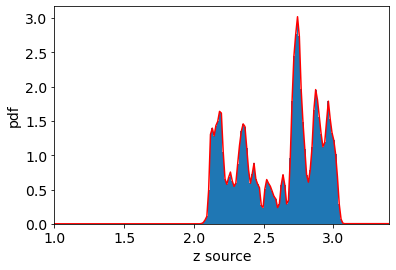

In [60]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)
plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.xlabel('z source')
plt.ylabel('pdf')

In [61]:
zint = np.linspace(0, 3.5, 1000)
zrand = np.random.choice(zint, 1000, p=pdf_zsource(zint)/np.sum(pdf_zsource(zint)))

In [62]:
Mc_relation = "Diemer15"
mdef = ["matter", "mean"] #differet terminology for ccl and clmm
delta_so=200


#model with the full redshift distribution
rp = np.logspace(-2, 3, 100)

model_mbias = np.zeros((rp.size, len(z_cl), len(mass_cl)))
model_magnification = np.zeros((rp.size, len(z_cl), len(mass_cl)))

for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        rp_Mpc = arcmin_to_Mpc(rp, z_cl[i,j], cosmo)
        models = magnification_biais_model(rp_Mpc, mass_cl[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)
        model_mbias[:,i,j] = models[0]
        model_magnification[:,i,j] = models[1]

../../magnification_library.py:106: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


## **Plotting figures**


## Example for one mass/z bin


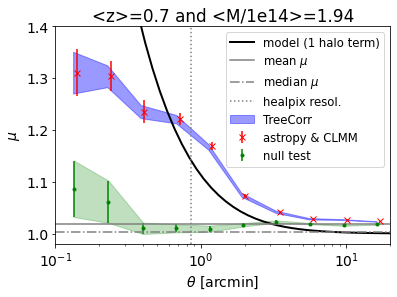

In [63]:
i,j = 2,3

plt.title("<z>="+str(round(z_cl[i,j],2)) + " and <M/1e14>="+str(round(mass_cl[i,j]/1e14,2)))

plt.fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - np.sqrt(np.diag(quant_NK[i,j][2])),\
                 y2 =  quant_NK[i,j][1]  + np.sqrt(np.diag(quant_NK[i,j][2])),color = 'blue', alpha=0.4, label='TreeCorr')

#plt.errorbar(quant_NK[i,j][0], quant_NK[i,j][1], yerr = np.sqrt(np.diag(quant_NK[i,j][2])),fmt='b-')#+  corr[i,j],yerr=np.sqrt(np.diag(quant_NK[i,j][2])),fmt='.-')
plt.errorbar(mu_profiles[i,j][0]*1.05, mu_profiles[i,j][1], yerr= mu_profiles[i,j][2], fmt='rx', label='astropy & CLMM')

plt.errorbar(mu_profiles_rand[i,j][0], mu_profiles_rand[i,j][1], yerr= mu_profiles_rand[i,j][2], fmt='g.', label='null test')
plt.fill_between(mu_profiles_rand[i,j][0], y1 = mu_profiles_rand[i,j][1] - mu_profiles_rand[i,j][2], \
                 y2 = mu_profiles_rand[i,j][1] + mu_profiles_rand[i,j][2], color='green', alpha=0.25)

plt.plot(rp, model_magnification[:,i,j],'k', lw=2,  label='model (1 halo term)')

plt.axhline(np.mean(gal_cat['magnification']),color='grey', label='mean $\mu$')
plt.axhline(np.median(gal_cat['magnification']),color='grey', ls='-.', label='median $\mu$')

plt.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')

plt.xscale('log')
plt.xlim(0.1,20)
plt.ylim(0.98,1.4)

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\mu$')

plt.legend(fontsize='small', ncol=1)


#### The errors are computed differently : 
- error measurements for TreeCorr => Var(rbin) = Var(all galaxies)/n_gal_rbin 
- error measurements for TreeCorr => Var(rbin) = Var(gal rbin)/n_gal_rbin

#### The profiles are offset by the mean magnification value of the sources, they do not tend to 1 at large radii (similar to profiles at random position shown in green)

## Magnification profiles for cluster in mass/z bins

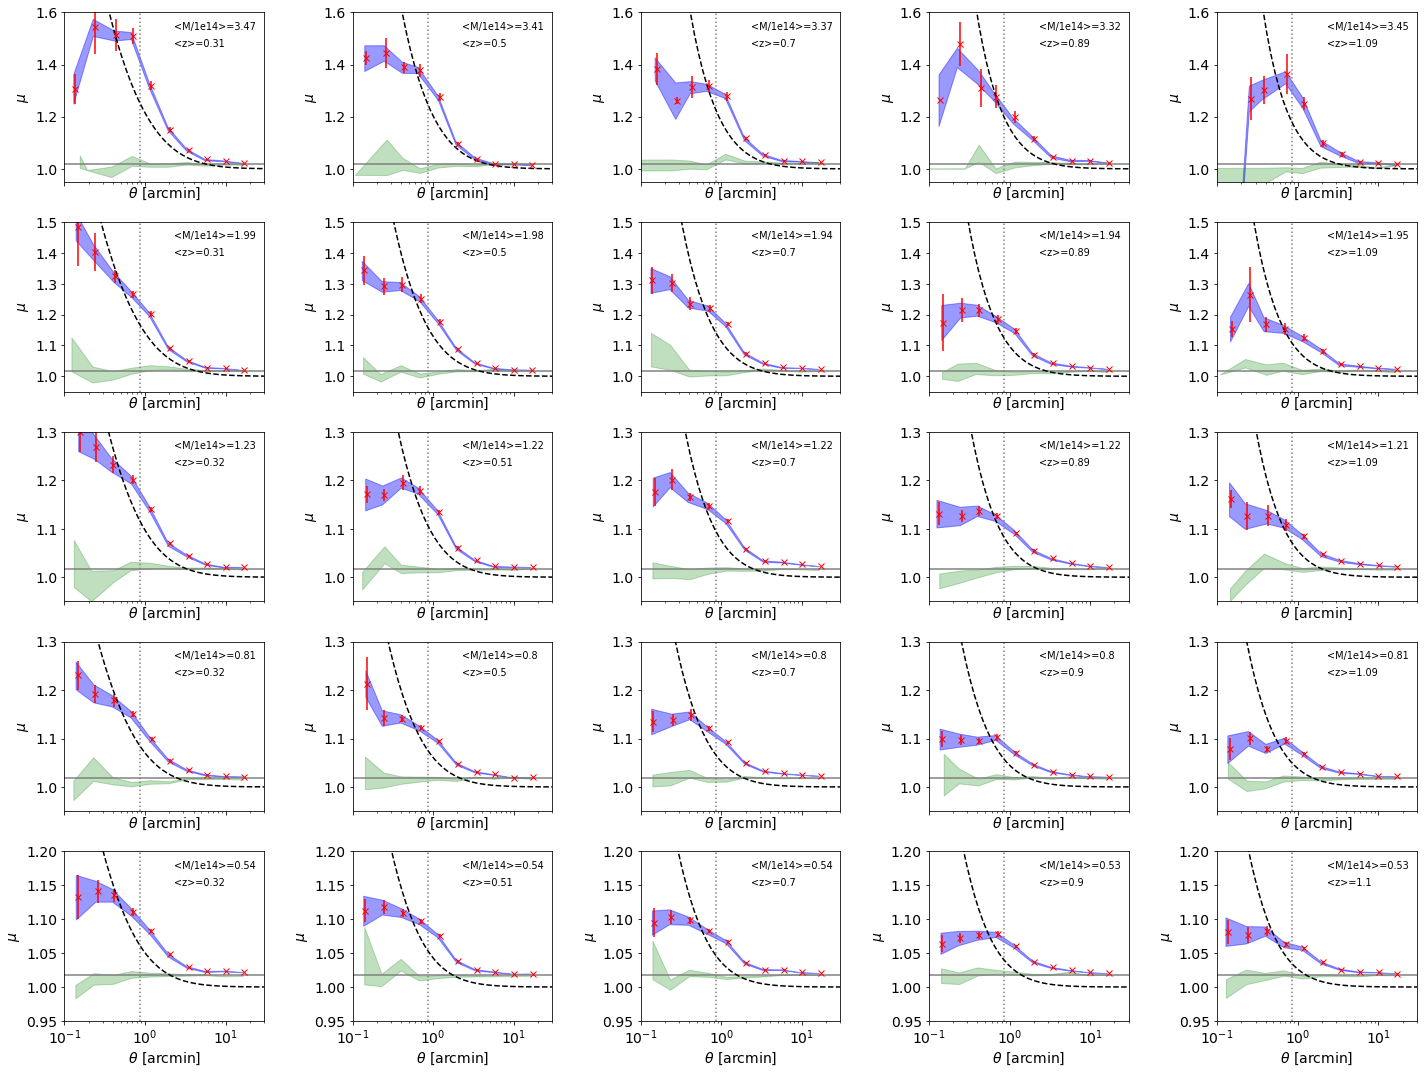

In [64]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)


for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        ax.fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - np.sqrt(np.diag(quant_NK[i,j][2])),\
                 y2 =  quant_NK[i,j][1]  + np.sqrt(np.diag(quant_NK[i,j][2])),color = 'blue', alpha=0.4)

        #ax.errorbar(quant_NK[i,j][0],quant_NK[i,j][1] ,yerr=np.sqrt(np.diag(quant_NK[i,j][2])),fmt='b.-')
        ax.errorbar(mu_profiles[i,j][0]*1.05, mu_profiles[i,j][1], yerr=mu_profiles[i,j][2], fmt='rx')
        ax.fill_between(mu_profiles_rand[i,j][0], y1 = mu_profiles_rand[i,j][1] - mu_profiles_rand[i,j][2], \
                 y2 = mu_profiles_rand[i,j][1] + mu_profiles_rand[i,j][2], color='green', alpha=0.25)

        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey')

        ax.axhline(np.mean(gal_cat['magnification']),color='grey', label='mean $\mu$')
        
        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
          
        ax.set_xlabel('$\\theta$ [arcmin]')
        ax.set_ylabel('$\mu$')

        ax.plot(rp, model_magnification[:,i,j],'k--')
        
plt.tight_layout()


axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,30)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(0.95,1.2)
    axes[3,i].set_ylim(0.95,1.3)
    axes[2,i].set_ylim(0.95,1.3)
    axes[1,i].set_ylim(0.95,1.5)
    axes[0,i].set_ylim(0.95,1.6)

## Magnification profiles for cluster in mass/z bins, corrected from the mean magnification excess

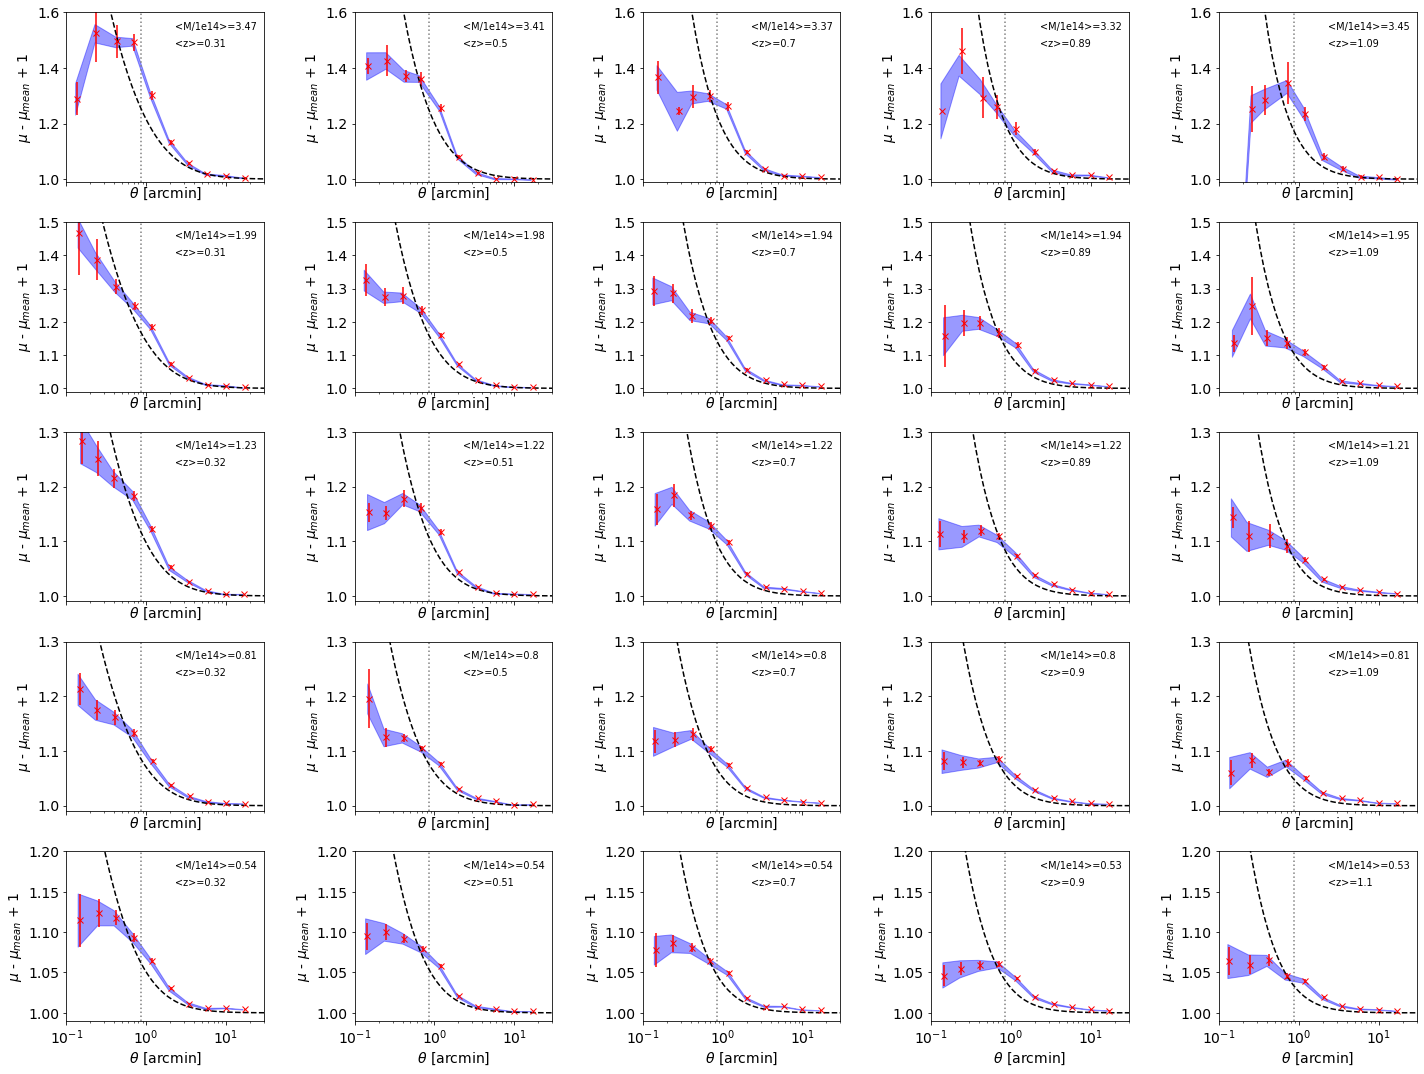

In [65]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)

corr = np.mean(gal_cat['magnification']) - 1

for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        ax.fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
                 y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color = 'blue', alpha=0.4)

        #ax.errorbar(quant_NK[i,j][0],quant_NK[i,j][1] ,yerr=np.sqrt(np.diag(quant_NK[i,j][2])),fmt='b.-')
        ax.errorbar(mu_profiles[i,j][0]*1.05, mu_profiles[i,j][1] - corr, yerr=mu_profiles[i,j][2], fmt='rx')


        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey')
     
        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
          
        ax.set_xlabel('$\\theta$ [arcmin]')
        ax.set_ylabel('$\mu$ - $\mu_{mean}$ + 1')

        ax.plot(rp, model_magnification[:,i,j],'k--')
        
plt.tight_layout()


axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,30)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(0.99,1.2)
    axes[3,i].set_ylim(0.99,1.3)
    axes[2,i].set_ylim(0.99,1.3)
    axes[1,i].set_ylim(0.99,1.5)
    axes[0,i].set_ylim(0.99,1.6)

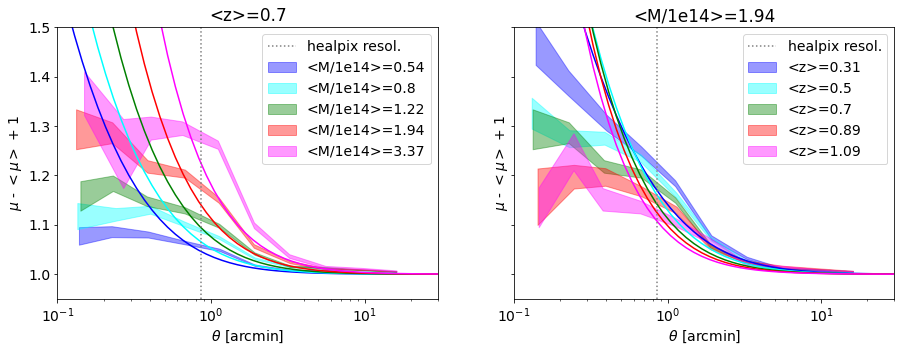

In [66]:
fig, axes = plt.subplots(1,2, figsize=[15,5], sharex=True, sharey=True)

colors = ['blue', 'cyan', 'green', 'red','magenta']


i = 2
axes[0].set_title("<z>="+str(round(z_cl[i,2],2)))
[axes[0].fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
                      y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color = colors[j], alpha=0.4, label = "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2))) for j in (0,1,2,3,4)]

[axes[0].plot(rp, model_magnification[:,i,j],'-', color=colors[j])  for j in (0,1,2,3,4)]

j = 3
axes[1].set_title( "<M/1e14>="+str(round(mass_cl[2,j]/1e14,2))) 
[axes[1].fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
                      y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color =  colors[i], alpha=0.4, label = "<z>="+str(round(z_cl[i,j],2))) for i in (0,1,2,3,4)]

[axes[1].plot(rp, model_magnification[:,i,j],'-', color=colors[i])  for i in (0,1,2,3,4)]

axes[0].axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')
axes[1].axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')



axes[0].set_xscale('log')
axes[0].set_xlim(0.1,30)
axes[0].set_ylim(0.95,1.5)

axes[0].set_xlabel('$\\theta$ [arcmin]')
axes[1].set_xlabel('$\\theta$ [arcmin]')

axes[0].set_ylabel('$\mu$ - $<\mu>$ + 1')
axes[1].set_ylabel('$\mu$ - $<\mu>$ + 1')

axes[0].legend()
axes[1].legend()

## Attempt to model the profiles by a beta model

In [67]:
def beta_model(rp, n0):
    """Beta model"""
    nc=0.75
    alpha=0
    beta = 0.5
    rc = nc * healpy.nside2resol(4096, arcmin = True)
    #rc = nc
    return n0 * (rp/rc)**alpha * (1 +(rp/rc)**2)**(-3*beta/2 + alpha/2) + 1

In [68]:
nparam = 1
popt = np.zeros((nparam,5,5))
pcov = np.zeros((nparam,nparam,5,5))

for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        ind = mu_profiles[i,j][2]>0
        popt[:,i,j], pcov[:,:,i,j] = curve_fit(beta_model, mu_profiles[i,j][0][ind], mu_profiles[i,j][1][ind]-corr, sigma = mu_profiles[i,j][2][ind], absolute_sigma=True, p0=(1), maxfev=2000)

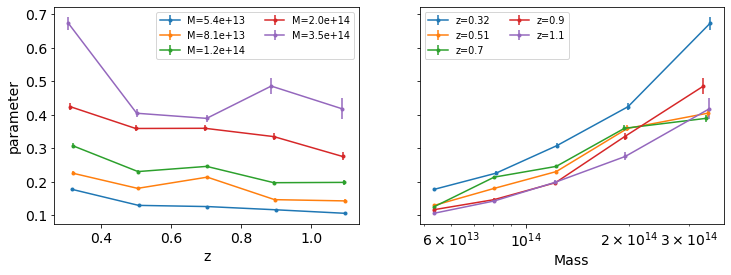

In [69]:
par = 0

fig, (ax1,ax2) = plt.subplots(1,2, figsize=[12,4], sharey=True)

#[plt.plot(z_cl[:,i],popt[par,:,i],'o-') for i in range(5)];
[ax1.errorbar(z_cl[:,i], popt[par,:,i], yerr = np.sqrt(pcov[par,par,:,i]), fmt='.-', label=f'M={mass_cl[0,i]:.1e}') for i in range(5)];
ax1.set_xlabel('z')
ax1.set_ylabel('parameter')
ax1.legend(ncol=2, fontsize='x-small')

[ax2.errorbar(mass_cl[i,:], popt[par,i,:], yerr = np.sqrt(pcov[par,par,i,:]), fmt='.-',label=f'z={z_cl[i,0]:.2}') for i in range(5)];
ax2.set_xscale('log')
ax2.set_xlabel('Mass')
ax2.legend(ncol=2, fontsize='x-small')

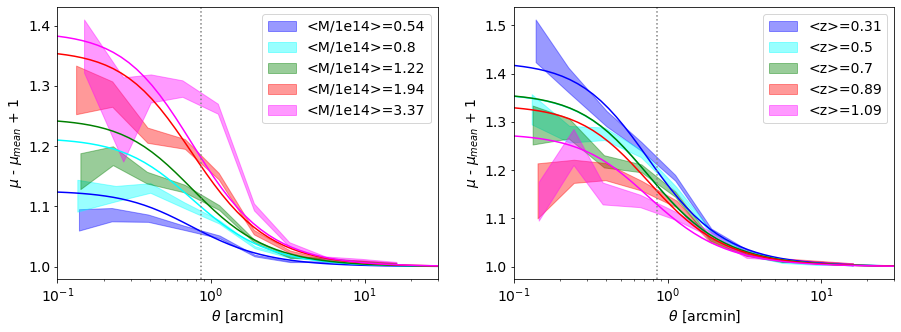

In [70]:
fig, axes = plt.subplots(1,2, figsize=[15,5], sharex=True)

colors = ['blue', 'cyan', 'green', 'red','magenta']


i = 2
[axes[0].fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
                      y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color = colors[j], alpha=0.4, label = "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2))) for j in (0,1,2,3,4)]

[axes[0].plot(rp,beta_model(rp,*popt[:,i,j]), color=colors[j])  for j in (0,1,2,3,4)]



j = 3
[axes[1].fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
                      y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color =  colors[i], alpha=0.4, label = "<z>="+str(round(z_cl[i,j],2))) for i in (0,1,2,3,4)]

[axes[1].plot(rp,beta_model(rp,*popt[:,i,j]),  color=colors[i])  for i in (0,1,2,3,4)]


axes[0].axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey')
axes[1].axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey')


axes[0].set_xscale('log')
axes[0].set_xlim(0.1,30)

axes[0].set_xlabel('$\\theta$ [arcmin]')
axes[1].set_xlabel('$\\theta$ [arcmin]')

axes[0].set_ylabel('$\mu$ - $\mu_{mean}$ + 1')
axes[1].set_ylabel('$\mu$ - $\mu_{mean}$ + 1')

axes[0].legend()
axes[1].legend()